Spam filter using data from https://www.geeksforgeeks.org/nlp/detecting-spam-emails-using-tensorflow-in-python/

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import string
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
nltk.download('stopwords')

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ericwelch/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
data = pd.read_csv('Emails.csv') # import data
data.head()

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\nth...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\n( see a...",0
2,3624,ham,"Subject: neon retreat\nho ho ho , we ' re arou...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\nthis deal is to ...,0


In [3]:
print(f'The data has {data.shape[0]} rows and {data.shape[1]} columns')

The data has 5171 rows and 4 columns


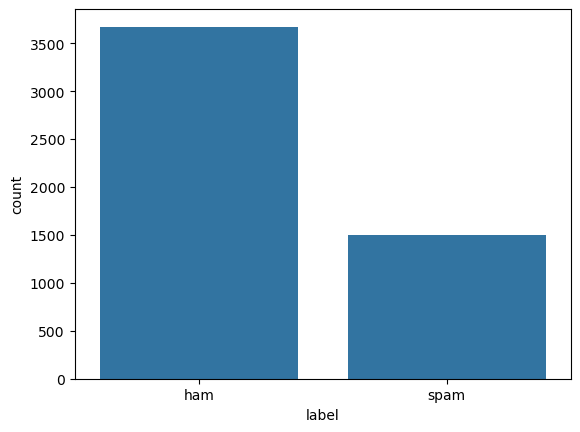

In [4]:
sns.countplot(x='label', data=data)
plt.show()

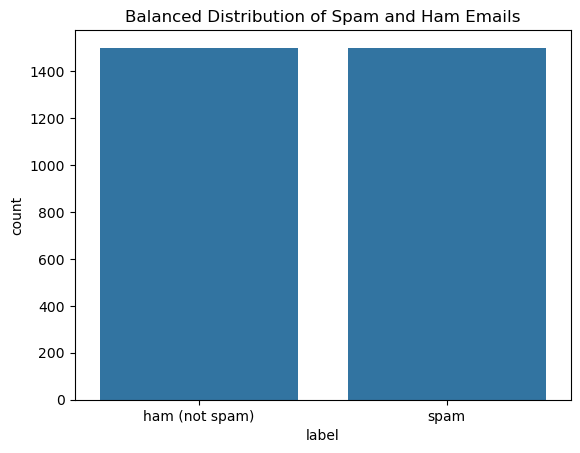

In [6]:
ham_msg = data[data['label'] == 'ham']
spam_msg = data[data['label'] == 'spam']

# downsample ham emails to match the number of spam emails
ham_msg_balanced = ham_msg.sample(n=len(spam_msg), random_state=42)

# combine balanced data
balanced_data = pd.concat([ham_msg_balanced, spam_msg]).reset_index(drop=True)

# visualize the balanced dataset
sns.countplot(x='label', data=balanced_data)
plt.title('Balanced Distribution of Spam and Ham Emails')
plt.xticks(ticks=[0,1], labels=['ham (not spam)', 'spam'])
plt.show()

In [7]:
# clean text by removing stopwords and punctuations, and by performing stemming/lemmatization
balanced_data['text'] = balanced_data['text'].str.replace('Subject', '')
balanced_data.head()

,Unnamed: 0,label,text,label_num
0,3444,ham,: conoco - big cowboy\ndarren :\ni ' m not sur...,0
1,2982,ham,: feb 01 prod : sale to teco gas processing\ns...,0
2,2711,ham,": california energy crisis\ncalifornia  , s p...",0
3,3116,ham,: re : nom / actual volume for april 23 rd\nwe...,0
4,1314,ham,: eastrans nomination changes effective 8 / 2 ...,0


In [8]:
punctuation_list = string.punctuation
def remove_punctuations(text):
    temp = str.maketrans('', '', punctuation_list)
    return text.translate(temp)

balanced_data['text'] = balanced_data['text'].apply(lambda x: remove_punctuations(x))
balanced_data.head()

,Unnamed: 0,label,text,label_num
0,3444,ham,conoco big cowboy\ndarren \ni m not sure if...,0
1,2982,ham,feb 01 prod sale to teco gas processing\nsal...,0
2,2711,ham,california energy crisis\ncalifornia  s pow...,0
3,3116,ham,re nom actual volume for april 23 rd\nwe ag...,0
4,1314,ham,eastrans nomination changes effective 8 2 0...,0


In [9]:
def remove_stopwords(text):
    stop_words = stopwords.words('english')

    imp_words = []

    # star important words
    for word in str(text).split():
        word = word.lower()

        if word not in stop_words:
            imp_words.append(word)

    output = ' '.join(imp_words)

    return output

balanced_data['text'] = balanced_data['text'].apply(lambda text: remove_stopwords(text))
balanced_data.head()

,Unnamed: 0,label,text,label_num
0,3444,ham,conoco big cowboy darren sure help know else a...,0
1,2982,ham,feb 01 prod sale teco gas processing sale deal...,0
2,2711,ham,california energy crisis california  power cr...,0
3,3116,ham,nom actual volume april 23 rd agree eileen pon...,0
4,1314,ham,eastrans nomination changes effective 8 2 00 p...,0


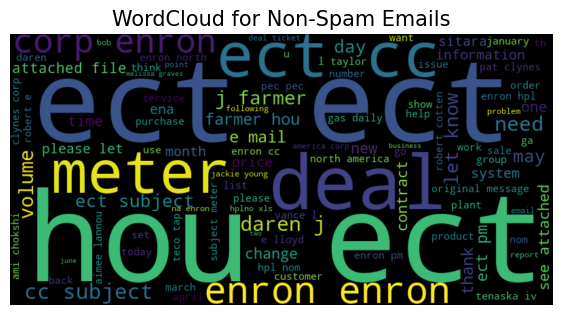

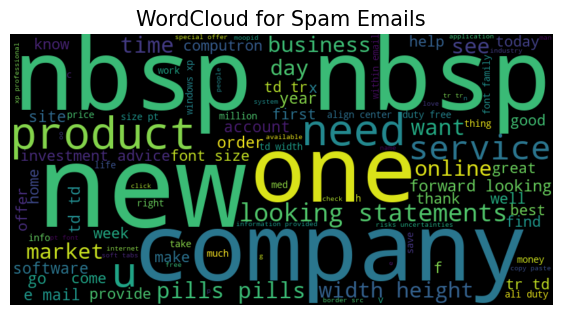

In [11]:
# find most frequent words using a word cloud
def plot_word_cloud(data, typ):
    email_corpus = ' '.join(data['text'])
    wc = WordCloud(background_color='black', max_words=100, width=800, height=400).generate(email_corpus)
    plt.figure(figsize=(7,7))
    plt.imshow(wc, interpolation='bilinear')
    plt.title(f'WordCloud for {typ} Emails', fontsize=15)
    plt.axis('off')
    plt.show()

plot_word_cloud(balanced_data[balanced_data['label'] == 'ham'], typ='Non-Spam')
plot_word_cloud(balanced_data[balanced_data['label'] == 'spam'], typ='Spam')

In [17]:
# tokenization (convert words into unique integers) and padding (all text has same length)
train_X, test_X, train_Y, test_Y = train_test_split(
    balanced_data['text'], balanced_data['label'], test_size=0.2, random_state=42
)

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_X)

train_sequences = tokenizer.texts_to_sequences(train_X)
test_sequences = tokenizer.texts_to_sequences(test_X)

max_len = 100  # Maximum sequence length
train_sequences = pad_sequences(train_sequences, maxlen=max_len, padding='post', truncating='post')
test_sequences = pad_sequences(test_sequences, maxlen=max_len, padding='post', truncating='post')

train_Y = (train_Y == 'spam').astype(int)
test_Y = (test_Y == 'spam').astype(int)

In [19]:
# define the model
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=32, input_length=max_len),
    tf.keras.layers.LSTM(16),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Output layer
])

model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [20]:
es = EarlyStopping(patience=3, monitor='val_accuracy', restore_best_weights=True)
lr = ReduceLROnPlateau(patience=2, monitor='val_loss', factor=0.5, verbose=0)

history = model.fit(
    train_sequences, train_Y,
    validation_data=(test_sequences, test_Y),
    epochs=20,
    batch_size=32,
    callbacks=[lr, es]
)

Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.5680 - loss: 0.6780 - val_accuracy: 0.8250 - val_loss: 0.5223 - learning_rate: 0.0010
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9395 - loss: 0.2428 - val_accuracy: 0.9583 - val_loss: 0.1677 - learning_rate: 0.0010
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9679 - loss: 0.1441 - val_accuracy: 0.9717 - val_loss: 0.1286 - learning_rate: 0.0010
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9746 - loss: 0.1167 - val_accuracy: 0.9633 - val_loss: 0.1439 - learning_rate: 0.0010
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9796 - loss: 0.0941 - val_accuracy: 0.9667 - val_loss: 0.1398 - learning_rate: 0.0010
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9804 - loss: 0.0910 - val_accuracy: 0.9667 - val_loss: 0.1415 - learning_rate: 5.0000e-04


In [27]:
test_loss, test_accuracy = model.evaluate(test_sequences, test_Y)
print(f'The loss is {test_loss:.3f}')
print(f'The accuracy is {test_accuracy * 100:.3f}%')

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9717 - loss: 0.1286
The loss is 0.129
The accuracy is 97.167%


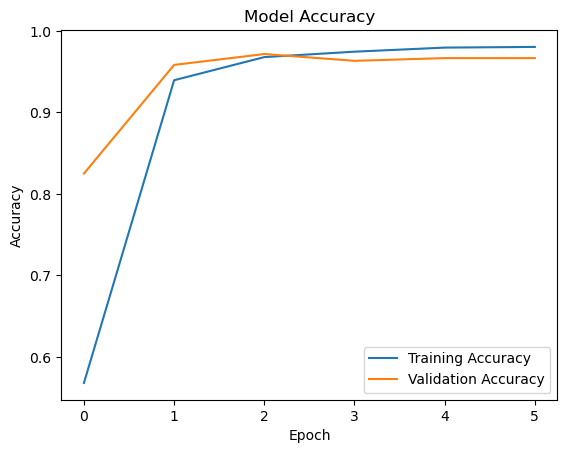

In [28]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()